In [1]:
import cv2
import detectron2
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os, random
import pandas as pd
import torch

In [2]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.structures import BoxMode

In [3]:
def basketball_dataset_function(dataset_type):
    list_dicts = []
    f = open(f'dataset/anno_{dataset_type}.json')
    data = json.load(f)
    for image_id, filename in enumerate(data):
        img = cv2.imread(f'dataset/images_{dataset_type}/{filename}')
        metadata_dict = {}
        metadata_dict['file_name'] = f'dataset/images_{dataset_type}/{filename}'
        metadata_dict['width'] = img.shape[1]
        metadata_dict['height'] = img.shape[0]
        metadata_dict['image_id'] = image_id
        metadata_dict['annotations'] = []
        
        for player in data[filename]:
            x, y, w, h = data[filename][player]['box']
            x, y, w, h = int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])
            metadata_dict['annotations'].append(
                 {
                  'bbox': [x, y, w, h],
                  'bbox_mode': BoxMode.XYWH_ABS,
                  'category_id': data[filename][player]['team'],
                 }
             )
        list_dicts.append(metadata_dict)
    return list_dicts

In [4]:
for d in ["train", "test"]:
    DatasetCatalog.register("basketball_dataset_" + d, lambda d=d: basketball_dataset_function(d))
    MetadataCatalog.get("basketball_dataset_" + d).set(thing_classes=["team1", "team2"])
basketball_metadata = MetadataCatalog.get("basketball_dataset_train")

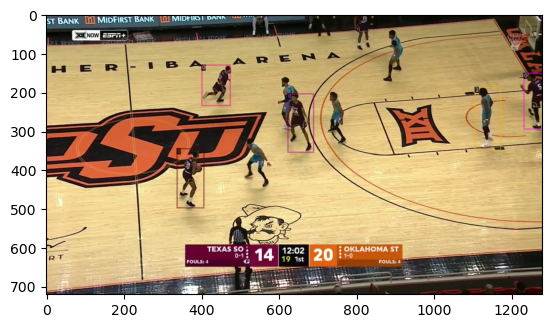

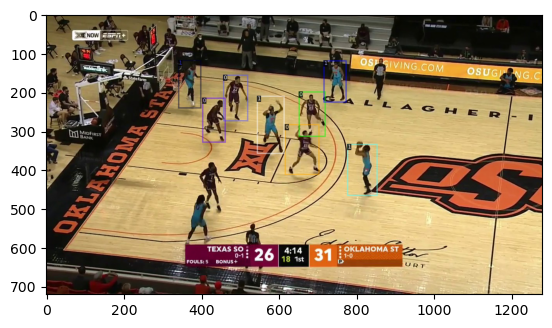

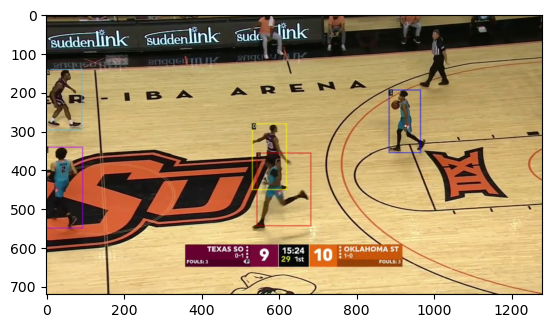

In [5]:
dataset_dicts = basketball_dataset_function('train')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.show()

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("basketball_dataset_train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[01/04 03:10:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[01/04 03:10:11 d2.data.build]: Removed 0 images with no usable annotations. 400 images left.
[01/04 03:10:11 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   team1    | 1378         |   team2    | 1368         |
|            |              |            |              |
|   total    | 2746         |            |              |
[01/04 03:10:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/04 03:10:11 d2.data.build]: Using training sampler TrainingSampler
[01/04 03:10:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[01/04 03:10:11 d2.data.common]: Serializing 400 elements to byte tensors and concatenating them all ...
[01/04 03:10:11 d2.data.commo

2023-01-04 03:10:11.250030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
model_final_721ade.pkl: 136MB [00:12, 10.5MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (3, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpo

In [8]:
trainer.train()

[01/04 03:10:24 d2.engine.train_loop]: Starting training from iteration 0


/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/04 03:10:31 d2.utils.events]:  eta: 0:04:49  iter: 19  total_loss: 1.76  loss_cls: 1.113  loss_box_reg: 0.4156  loss_rpn_cls: 0.1796  loss_rpn_loc: 0.02768  time: 0.2945  data_time: 0.0066  lr: 4.9953e-06  max_mem: 4919M
[01/04 03:10:37 d2.utils.events]:  eta: 0:04:43  iter: 39  total_loss: 1.685  loss_cls: 1.026  loss_box_reg: 0.4597  loss_rpn_cls: 0.1566  loss_rpn_loc: 0.02648  time: 0.2943  data_time: 0.0024  lr: 9.9902e-06  max_mem: 4919M
[01/04 03:10:43 d2.utils.events]:  eta: 0:04:37  iter: 59  total_loss: 1.535  loss_cls: 0.8921  loss_box_reg: 0.4715  loss_rpn_cls: 0.1573  loss_rpn_loc: 0.02825  time: 0.2940  data_time: 0.0025  lr: 1.4985e-05  max_mem: 4919M
[01/04 03:10:49 d2.utils.events]:  eta: 0:04:31  iter: 79  total_loss: 1.346  loss_cls: 0.7249  loss_box_reg: 0.4284  loss_rpn_cls: 0.1633  loss_rpn_loc: 0.0236  time: 0.2942  data_time: 0.0026  lr: 1.998e-05  max_mem: 4919M
[01/04 03:10:55 d2.utils.events]:  eta: 0:04:25  iter: 99  total_loss: 1.166  loss_cls: 0.5833  l

[01/04 03:14:05 d2.utils.events]:  eta: 0:01:17  iter: 739  total_loss: 0.6579  loss_cls: 0.2677  loss_box_reg: 0.3635  loss_rpn_cls: 0.01887  loss_rpn_loc: 0.01706  time: 0.2967  data_time: 0.0027  lr: 0.00018482  max_mem: 4919M
[01/04 03:14:11 d2.utils.events]:  eta: 0:01:11  iter: 759  total_loss: 0.6889  loss_cls: 0.2618  loss_box_reg: 0.3985  loss_rpn_cls: 0.01522  loss_rpn_loc: 0.01663  time: 0.2967  data_time: 0.0025  lr: 0.00018981  max_mem: 4919M
[01/04 03:14:17 d2.utils.events]:  eta: 0:01:05  iter: 779  total_loss: 0.6754  loss_cls: 0.2543  loss_box_reg: 0.3765  loss_rpn_cls: 0.01566  loss_rpn_loc: 0.01791  time: 0.2967  data_time: 0.0025  lr: 0.00019481  max_mem: 4919M
[01/04 03:14:23 d2.utils.events]:  eta: 0:00:59  iter: 799  total_loss: 0.634  loss_cls: 0.2397  loss_box_reg: 0.344  loss_rpn_cls: 0.01682  loss_rpn_loc: 0.01682  time: 0.2967  data_time: 0.0025  lr: 0.0001998  max_mem: 4919M
[01/04 03:14:29 d2.utils.events]:  eta: 0:00:53  iter: 819  total_loss: 0.609  loss

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/coco/annotations/instances_val2017.json'

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("basketball_dataset_test", )
predictor = DefaultPredictor(cfg)

In [ ]:
test_dataset_dicts = basketball_dataset_function('test')

In [ ]:
for d in random.sample(test_dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=basketball_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()